In [31]:
import numpy as np 
import random 
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import pandas as pd

## Build the Binary Tree

In [5]:
class Node():
  def __init__(self, parent=None, children=[], val=None):
    self.parent = parent
    self.children = children
    self.val = val
    self.visited = 0 

  def visit(self):
    self.visit = True 

  def visited_status(self):
    return self.visit

  def is_terminal(self):
    if len(self.children) == 0: 
        return True
    return False
  def reward(self):
    return self.val

In [7]:
class Tree():
  def __init__(self):
    self.root = Node()
  def make_branch(self, depth=2):
    total_nodes = 1
    parents = []
    parents.append(self.root)
    for level in range(1, depth):
      childs = []
      for parent in parents: 
        parent.children = self.make_branch_node(parent=parent)
        total_nodes += 2
        for child in parent.children:
          childs.append(child)
      parents = childs.copy()
    self.leaf_nodes = childs

  def make_branch_node(self, parent):
    children = []
    for i in range(2):
      children.append(Node(parent=parent))
    return children

  def assign_leaf_val(self):
    self.leaf_nodes_vals = []
    for leaf in self.leaf_nodes: 
      leaf.val = random.uniform(0, 100)
      self.leaf_nodes_vals.append(leaf.val)


In [8]:
# Tree Parameters
random.seed(1)
branch = 2 
depth = 12

tree = Tree()
tree.make_branch(depth=depth)
tree.assign_leaf_val()
print('maximum value of leaf:',max(tree.leaf_nodes_vals))

maximum value of leaf: 99.87565168726059


## Monte Carlo Algorithm

In [12]:
class MCTS:
    def __init__(self, c=1.0):
        self.Q = defaultdict(float)  
        self.N = defaultdict(float)  
        self.children = dict() 
        self.c = c

    def choose(self, node):
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")
        if node not in self.children:
            return node.find_random_child()
        def score(n):
            if self.N[n] == 0:
                return float("-inf")  
            return self.Q[n] / self.N[n] 
        return max(self.children[node], key=score)

    def run(self, node, num_rollout):
        path = self.select(node)
        leaf = path[-1]
        self.expand(leaf)
        reward = 0
        for i in range(num_rollout):
            reward += self.simulate(leaf)
        self.backup(path, reward)

    def select(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  

    def expand(self, node):
        if node in self.children:
            return  
        try:
          self.children[node] = {node.children[0], node.children[1]} 
        except: pass 
        

    def simulate(self, node):
        while True:
            if len(node.children) is 0: return node.val 
            else: node = self.random_select(node)

    def random_select(self, node:Node):
      return random.choice(node.children)

    def backup(self, path, reward):
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward

    def _uct_select(self, node):
        is_all_children_expanded = all(n in self.children for n in self.children[node])
        if not is_all_children_expanded:
            raise ValueError("Can only select fom fully expanded node")

        log_N_parent = math.log(self.N[node])

        def uct(n):
            return self.Q[n] / self.N[n] + self.c * math.sqrt(log_N_parent / self.N[n])

        return max(self.children[node], key=uct)

In [13]:
def mcts_playout(depth, num_iter, num_rollout, c):
  tree = Tree()
  tree.make_branch(depth=depth)
  tree.assign_leaf_val()
  print('maximum value of leaf:',max(tree.leaf_nodes_vals))
  root = tree.root

  mcts = MCTS(c=c)
  while True:
      for _ in range(num_iter):
          mcts.run(root, num_rollout=num_rollout)
      root = mcts.choose(root)
      if root.is_terminal():
          return root.val

random.seed(2)
branch = 2 
depth = 12

mcts_playout(depth=depth, num_iter=100, num_rollout=1, c=50)

maximum value of leaf: 99.96958012914389


92.00643606526125

## 3 The experiment

In [33]:
depth = 12
num_iter = 50
num_rollout = 1
c_values = [0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 5000]

num_experiments = 30
results = defaultdict(list)

for c in c_values:
    for i in range(num_experiments):
        found_max = mcts_playout(depth=depth, num_iter=num_iter, num_rollout=num_rollout, c=c)
        print('max found', found_max)
        results[c].append(found_max)

maximum value of leaf: 99.99667537765507
max found 51.09758197902641
maximum value of leaf: 99.99723024073883
max found 98.79186368412587
maximum value of leaf: 99.92912692797282
max found 76.74211417862152
maximum value of leaf: 99.98051754873526
max found 72.30556573929084
maximum value of leaf: 99.92988524068316
max found 65.1449545100814
maximum value of leaf: 99.94111389973017
max found 85.39856210640812
maximum value of leaf: 99.87306020744398
max found 69.84461520037434
maximum value of leaf: 99.94597087601888
max found 81.25289697108947
maximum value of leaf: 99.9542215657796
max found 74.82270120686727
maximum value of leaf: 99.96240368462543
max found 79.35133777864911
maximum value of leaf: 99.99748956145736
max found 91.60896155490067
maximum value of leaf: 99.99970310457542
max found 90.26246942700458
maximum value of leaf: 99.97832107361117
max found 99.35641464859363
maximum value of leaf: 99.91007846574605
max found 98.17818330998578
maximum value of leaf: 99.9823656600

Text(0, 0.5, 'optimal value')

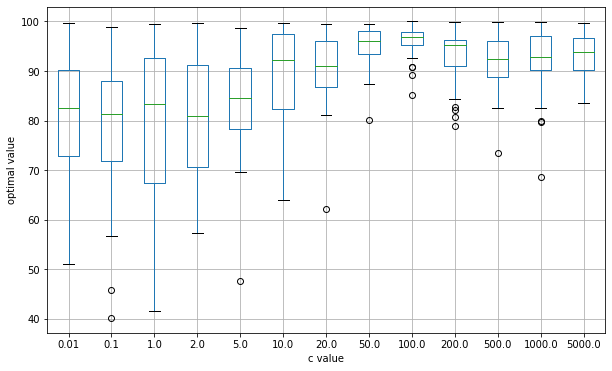

In [34]:
df = pd.DataFrame(results)
df.boxplot(figsize=(10,6))
plt.xlabel("c value")
plt.ylabel("optimal value")
